In [1]:
import numpy as np
import os
# plotting figure
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# Using similar values as in online handbook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


In [2]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)


In [4]:
# first fifty elements in the series is the training data, the last one is the label (to be predicted).
n_steps = 50 
# Generating random 10,000 sequences, thus the dataset consistes of 10,000 instances, each representing a sequence
series = generate_time_series(10000, n_steps + 1) 
# Splitting the series into 70% training, 20% validation, and 10% test datasets.
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]  # The last element is always the label (to be predicted).
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1] # The last element is always the label (to be predicted).
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]  # The last element is always the label (to be predicted).

In [5]:
series.shape

(10000, 51, 1)

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [16]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [17]:
# Let's display validate set shape:
X_valid.shape

(2000, 50, 1)

In [18]:
# let's show the shape of one of the validation sequences to be displayed as plot:
X_valid[0, :, 0].shape


(50,)

Saving figure time_series_plot


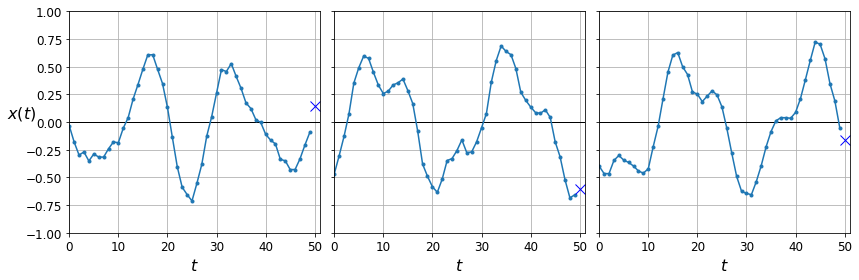

In [24]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")  # this shows the main sequence
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10) # This shows the label (GT)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")  # This shows prediction of the next step.
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

# Our figure to contain three subfigures
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

In [31]:
# Baseline metrics: consider prediction to be equal to the last element of the training set.
# (DO it for all 2000 sequences and measure the average)
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.019855332

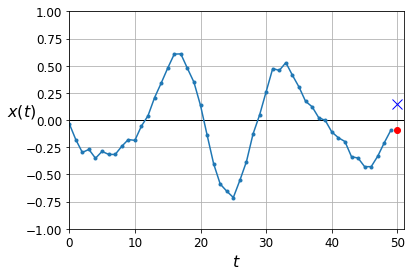

In [32]:
# Display only one of such sequences where the red-dot is the prediction, and blue-cross is the actuval value
# (remember, the prediction is just equal to the last element of training sequence)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [33]:
# Now, instead of taking the last element of the sequence as the next element prediction, let's 
# do one bit smarter.
# Implementing simple linear regression (through a single fully connected layer of NN) to predict next such value!
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 39us/sample - loss: 0.1003 - val_loss: 0.0573
Epoch 2/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0392 - val_loss: 0.0284
Epoch 3/20
7000/7000 [==============================] - 0s 26us/sample - loss: 0.0211 - val_loss: 0.0167
Epoch 4/20
7000/7000 [==============================] - 0s 26us/sample - loss: 0.0135 - val_loss: 0.0121
Epoch 5/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0105 - val_loss: 0.0099
Epoch 6/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0091 - val_loss: 0.0087
Epoch 7/20
7000/7000 [==============================] - 0s 26us/sample - loss: 0.0081 - val_loss: 0.0080
Epoch 8/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0074 - val_loss: 0.0072
Epoch 9/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0069 - val_loss: 0.0066
Epoch 1

In [37]:
# And confirm that linear regression as a method for next value prediction is better than just
# using the last element of the sequenc!
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 16us/sample - loss: 0.0041


0.004144457932561636

In [38]:
# Add code for plotting learning curves
# Needed to see how good we are at learning and if we are not overfitting
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

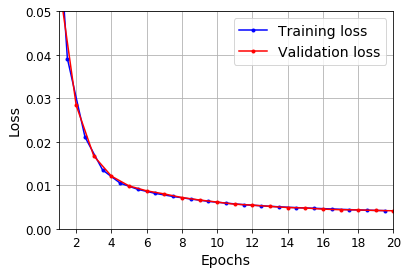

In [39]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()
# as one can see, 20 epochs is just fine, nothing overfits!

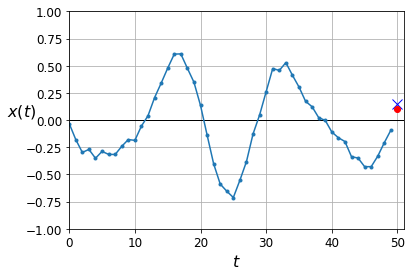

In [40]:
# Let's now display the next predicted value for the first sequence
# Again, the red dot is teh prediction and the blue-cross is the label.
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [17]:
# Implementing a simple RNN

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 293us/sample - loss: 0.0961 - val_loss: 0.0479
Epoch 2/20
7000/7000 [==============================] - 1s 199us/sample - loss: 0.0362 - val_loss: 0.0293
Epoch 3/20
7000/7000 [==============================] - 1s 197us/sample - loss: 0.0246 - val_loss: 0.0218
Epoch 4/20
7000/7000 [==============================] - 1s 209us/sample - loss: 0.0193 - val_loss: 0.0178
Epoch 5/20
7000/7000 [==============================] - 1s 206us/sample - loss: 0.0162 - val_loss: 0.0153
Epoch 6/20
7000/7000 [==============================] - 1s 204us/sample - loss: 0.0143 - val_loss: 0.0137
Epoch 7/20
7000/7000 [==============================] - 2s 251us/sample - loss: 0.0130 - val_loss: 0.0127
Epoch 8/20
7000/7000 [==============================] - 1s 213us/sample - loss: 0.0122 - val_loss: 0.0120
Epoch 9/20
7000/7000 [==============================] - 1s 207us/sample - loss: 0.0118 - val_loss: 0.011

In [18]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 97us/sample - loss: 0.0113


0.01130186316370964

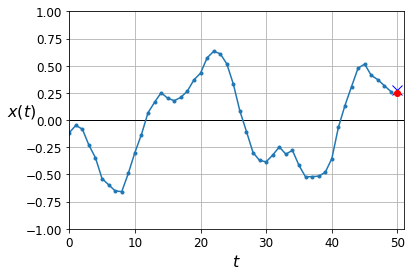

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [20]:
# Implementing a Deep-RNN

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 896us/sample - loss: 0.0501 - val_loss: 0.0124
Epoch 2/20
7000/7000 [==============================] - 5s 692us/sample - loss: 0.0073 - val_loss: 0.0058
Epoch 3/20
7000/7000 [==============================] - 5s 675us/sample - loss: 0.0053 - val_loss: 0.0048
Epoch 4/20
7000/7000 [==============================] - 5s 664us/sample - loss: 0.0047 - val_loss: 0.0042
Epoch 5/20
7000/7000 [==============================] - 5s 679us/sample - loss: 0.0043 - val_loss: 0.0041
Epoch 6/20
7000/7000 [==============================] - 5s 667us/sample - loss: 0.0041 - val_loss: 0.0042
Epoch 7/20
7000/7000 [==============================] - 5s 675us/sample - loss: 0.0037 - val_loss: 0.0037
Epoch 8/20
7000/7000 [==============================] - 5s 675us/sample - loss: 0.0037 - val_loss: 0.0035
Epoch 9/20
7000/7000 [==============================] - 5s 664us/sample - loss: 0.0036 - val_loss: 0.003

In [21]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 325us/sample - loss: 0.0029


0.0029184530694037676

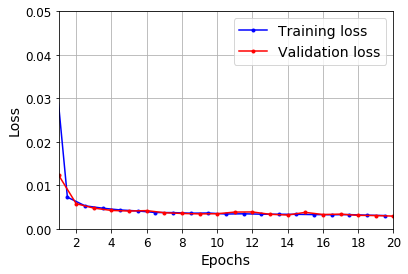

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

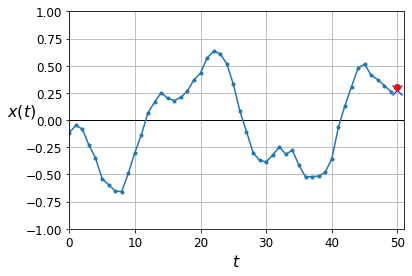

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [24]:
# generating a multiple-steps sequence:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

Saving figure forecast_ahead_plot


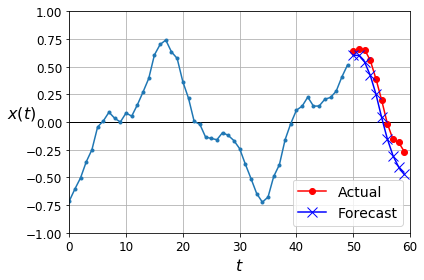

In [25]:
# code for displaying several steps forecast:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [26]:
# generate multiple sequences with 10 steps ahead for simulteous multi-step prediction
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [27]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [32]:
Y_pred.shape

(2000, 10)

In [33]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.029740486

In [34]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [31]:
# Comparing the validation loss generated by flat NN model.
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 42us/sample - loss: 0.1334 - val_loss: 0.0605
Epoch 2/20
7000/7000 [==============================] - 0s 30us/sample - loss: 0.0498 - val_loss: 0.0424
Epoch 3/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0385 - val_loss: 0.0356
Epoch 4/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0332 - val_loss: 0.0313
Epoch 5/20
7000/7000 [==============================] - 0s 29us/sample - loss: 0.0298 - val_loss: 0.0284
Epoch 6/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0274 - val_loss: 0.0264
Epoch 7/20
7000/7000 [==============================] - 0s 33us/sample - loss: 0.0256 - val_loss: 0.0248
Epoch 8/20
7000/7000 [==============================] - 0s 32us/sample - loss: 0.0244 - val_loss: 0.0239
Epoch 9/20
7000/7000 [==============================] - 0s 36us/sample - loss: 0.0234 - val_loss: 0.0229
Epoch 1

In [35]:
# And finally, comparing validation loss of prediction 10 consequtive values by RNN:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 666us/sample - loss: 0.0670 - val_loss: 0.0341
Epoch 2/20
7000/7000 [==============================] - 3s 493us/sample - loss: 0.0267 - val_loss: 0.0195
Epoch 3/20
7000/7000 [==============================] - 3s 482us/sample - loss: 0.0189 - val_loss: 0.0195
Epoch 4/20
7000/7000 [==============================] - 4s 501us/sample - loss: 0.0152 - val_loss: 0.0129
Epoch 5/20
7000/7000 [==============================] - 3s 488us/sample - loss: 0.0136 - val_loss: 0.0125
Epoch 6/20
7000/7000 [==============================] - 3s 483us/sample - loss: 0.0126 - val_loss: 0.0128
Epoch 7/20
7000/7000 [==============================] - 4s 513us/sample - loss: 0.0121 - val_loss: 0.0107
Epoch 8/20
7000/7000 [==============================] - 3s 486us/sample - loss: 0.0112 - val_loss: 0.0109
Epoch 9/20
7000/7000 [==============================] - 3s 491us/sample - loss: 0.0109 - val_loss: 0.010

In [ ]:
#Note that RNN shows the smallest loss value